In [ ]:
#| default_exp intrinsics

# Intrinsics 

> The Intrinsics part of a camera model that transforms points to.from the
 3D camera grame into the 2D image frame possibly with a distortion model. 

Need to check (and possible integrate) the [code from pixlib](https://github.com/cvg/pixloc/blob/master/pixloc/pixlib/geometry/wrappers.py#L224) that provides and camera model both for torch and numpy. The discussoions in [this tweet](https://twitter.com/pesarlin/status/1558087424445652998?s=27&t=ILeCIQvS1YTIJL8yMhYFMg) anre also useful. See [pinhole model in kornia](https://kornia.readthedocs.io/en/latest/geometry.camera.pinhole.html) - no distortions and use 4x4 homogenous representation all the way also with batch dimensions.

Also look at [this code](https://github.com/princeton-vl/DPVO/blob/main/dpvo/projective_ops.py)

Suggest a Pose API, Intrinsics API and camera API that include both.

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
from PIL import Image
from IPython.display import display

from nbdev.showdoc import *
from fastcore.utils import *    # to get patch
from fastcore.test import *


In [ ]:
#|export

from typing import Tuple
# import torch
import numpy as np
import cv2
from easydict import EasyDict as edict

# Geometric camera model

The class `Intrinsics` models a pinhole camera with distortions. Useful books are:

* The book [Computer Vision: Algorithms and Applications, 2nd ed.](http://szeliski.org/Book/),  [Richard Szeliski](https://szeliski.org/RichardSzeliski.htm), 2022 that can be freely downloaded.
* [Multiple View Geometry in Computer Vision, 2nd ed.](https://www.robots.ox.ac.uk/~vgg/hzbook/), Hartley and Zisserman, , Cambridge University Press, 2004
* [An Invitation to 3-D Vision (pdf)](https://www.eecis.udel.edu/~cer/arv/readings/old_mkss.pdf), Yi Ma, Jana Koˇseck´a, Stefano Soatto, Shankar Sastry, 2001


In [ ]:
#|export

SUPPORTED_CAMERA_MODELS = dict(
    SIMPLE_PINHOLE = dict(id=0, n_params=3, params_str='f, cx, cy'), 
    PINHOLE        = dict(id=1, n_params=4,params_str='fx, fy, cx, cy'), 
    SIMPLE_RADIAL  = dict(id=2, n_params=4,params_str='f, cx, cy, k'), 
    RADIAL         = dict(id=3, n_params=5,params_str='f, cx, cy, k1, k2'), 
    OPENCV         = dict(id=4, n_params=8,params_str='fx, fy, cx, cy, k1, k2, p1, p2'), 
    OPENCV_FISHEYE = dict(id=5, n_params=8,params_str='fx, fy, cx, cy, k1, k2, k3, k4'), 
    FULL_OPENCV    = dict(id=6, n_params=12,params_str='fx, fy, cx, cy, k1, k2, p1, p2, k3, k4, k5, k6'), 
    FOV            = dict(id=7, n_params=5,params_str='fx, fy, cx, cy, omega'), 
    OPENCV5        = dict(id=-1, n_params=9,params_str='fx, fy, cx, cy, k1, k2, p1, p2, k3'),
    UNKNOWN        = dict(id=-1, n_params=0,params_str='[]'), 
)

def to_homogeneous(points):
    # from https://github.com/cvg/pixloc/blob/master/pixloc/pixlib/geometry/utils.py
    """Convert N-dimensional points to homogeneous coordinates.
    Args:
        points: torch.Tensor or numpy.ndarray with size (..., N).
    Returns:
        A torch.Tensor or numpy.ndarray with size (..., N+1).
    """
    if isinstance(points, np.ndarray):
        pad = np.ones((points.shape[:-1]+(1,)), dtype=points.dtype)
        return np.concatenate([points, pad], axis=-1)
    # elif isinstance(points, torch.Tensor):
    #     pad = points.new_ones(points.shape[:-1]+(1,))
    #     return torch.cat([points, pad], dim=-1)
    else:
        raise ValueError


def from_homogeneous(points):
    """Remove the homogeneous dimension of N-dimensional points.
    Args:
        points: torch.Tensor or numpy.ndarray with size (..., N+1).
    Returns:
        A torch.Tensor or numpy ndarray with size (..., N).
    """
    return points[..., :-1] / points[..., -1:]


In [ ]:
#|export

class Intrinsics:
    'Camera intrinsic model'
    def __init__(self, 
                 camera_model_name: str,   # One of the keys in SUPPORTED_CAMERA_MODELS
                 width: int,               # width of the image in pixels
                 height: int,              # height of the image in pixels
                 params: list):            # parameters, in COLMAP conventions
        # prior_focal_length : 1 if we have confidence in the modelparameters and 0 if we do not trust the model parameters

        if camera_model_name not in SUPPORTED_CAMERA_MODELS:
            raise ValueError(f'Camera model ["{camera_model_name}"] not recognized as colmap camera model')
        
        param_names = SUPPORTED_CAMERA_MODELS[camera_model_name]['params_str'].split(',')
        param_names = [p.strip() for p in param_names]
        if len(param_names) != len(params):
            raise ValueError(f'{camera_model_name} expectes {len(param_names)} parameters but got {len(params)}') 

        self._w = width
        self._h = height

        self._camera_model_name = camera_model_name
        self._set_params(camera_model_name, params)

    @staticmethod
    def supported_camera_models():
        print('List of supported camera models and their parameters')
        print(55*'_')
        for m in SUPPORTED_CAMERA_MODELS:
            p = SUPPORTED_CAMERA_MODELS[m]['params_str']
            print(f'{m:20}: {p}')


    def __str__(self):
        s  = f'Camera: {self.camera_model_name}\n'
        s += f'  w,h={self.width,self.height}\n'
        s += f'  params: {self.params}\n'
        s += f'  cx,cy= ({self.cx},{self.cy})\n'
        s += f'  fx,fy= ({self.fx},{self.fy})\n'
        s += f'  distortions: {self.distortions}\n'


        return s

    __repr__ = __str__

    @staticmethod
    def from_pinhole_model(fx: float,   # Focal length (x) in pixels
                           fy: float,   # Focal length (y) in pixels. fy might be equal to fx (SIMPLE_PINHOLE model) or different (PINHOLE model)
                           cx:float,    # Camera center (x) in pixels
                           cy: float,   # Camera center (y) in pixels
                           width: int,  # Image width in pixels
                           height: int  # Image height in pixels
                           ) -> 'Intrinsics':
        'Contructing camera intrinsics model from opencv compatible data'
        if fx == fy:
            camera_model_name = 'SIMPLE_PINHOLE'
            params = [fx, cx, cy]
        else:
            camera_model_name = 'PINHOLE'
            params = [fx, fy, cx, cy]

        return Intrinsics(camera_model_name,width, height, params)


    @staticmethod
    def from_opencv_model(K: np.ndarray, # 3x3 camera matrix
                          distortions: np.ndarray, # distortion array as produced by OpenCv
                          width: int, # Camera width in pixels
                          height: int # Camera height in pixels
                         ) -> 'Intrinsics':
        'Contructing camera intrinsics model from opencv compatible data'
        if not isinstance(distortions, list):
            if len(distortions.shape) == 2:
                distortions = distortions.squeeze()
            distortions= distortions.tolist()
     
        fx = K[0,0]
        cx = K[0,2]
        fy = K[1,1]
        cy = K[1,2]

        params = [fx, fy, cx, cy]
        if len(distortions) == 4:
            camera_model_name = 'OPENCV'
            params += distortions
        elif len(distortions) == 5:
            camera_model_name = 'OPENCV5'
            params += distortions
        elif len(distortions) == 8:
            camera_model_name = 'FULL_OPENCV'
            params += distortions
        else:
            raise ValueError(f'Do not support opencv model with {len(distortions)} parameters')

        return Intrinsics(camera_model_name,width, height, params)

    @staticmethod
    def from_opencv_fisheye_model(K: np.ndarray, # 3x3 camera matrix
                          distortions: np.ndarray, # distortion array for OpenCv fisheye model, should consist of 4 distrortion parameters
                          width: int, # Camera width in pixels
                          height: int # Camera height in pixels
                         ) -> 'Intrinsics':
        'Contructing camera intrinsics model from data compatible with opencv fisheye model'
        if not isinstance(distortions, list):
            if len(distortions.shape) == 2:
                distortions = distortions.squeeze()
            distortions= distortions.tolist()
     
        fx = K[0,0]
        cx = K[0,2]
        fy = K[1,1]
        cy = K[1,2]

        params = [fx, fy, cx, cy]
        if len(distortions) == 4:
            camera_model_name = 'OPENCV'
            params += distortions
        else:
            raise ValueError(f'Do not support fisheye-opencv model with {len(distortions)} parameters')

        return Intrinsics(camera_model_name,width, height, params)

    @staticmethod
    def from_test_model(as_full_opencv=False):
        'Contructing camera intrinsics model from opencv calibration tutorial'
        w, h = 640, 480 

        distortions = np.array(
            [
            [-2.6637260909660682e-01], 
            [-3.8588898922304653e-02], 
            [1.7831947042852964e-03], 
            [-2.8122100441115472e-04], 
            [2.3839153080878486e-01]
            ]
        )

        if as_full_opencv:
            distortions = np.array(
                [
                [-2.6637260909660682e-01], 
                [-3.8588898922304653e-02], 
                [1.7831947042852964e-03], 
                [-2.8122100441115472e-04], 
                [2.3839153080878486e-01],
                [0.0],
                [0.0],
                [0.0]
                ]
        )

        mtx = np.array(
            [
                [5.3591573396163199e+02, 0.,                     3.4228315473308373e+02],
                [0.,                     5.3591573396163199e+02, 2.3557082909788173e+02],
                [0.,                     0.,                     1.]
            ]
        )

        return Intrinsics.from_opencv_model(mtx,distortions,w, h)

    #----------------------------------------------------------
    # Access functions
    #----------------------------------------------------------
    @property
    def camera_model_name(self) -> str:
        'Returns the name of the camera model, e.g. `OPENCV`'
        return self._camera_model_name

    @property
    def fx(self):
        'Returns the (x) focal point in pixels'
        return self._K[0,0]

    @property
    def fy(self):
        'Returns the (y) forcal point in pixels'
        return self._K[1,1]

    @property
    def cx(self):
        'Returns the x coordinate of the camera center in pixels'
        return self._K[0,2]

    @property
    def cy(self):
        'Returns the y coordinate of the camera center in pixels'
        return self._K[1,2]

    @property
    def w(self):
        'Returns the width of image, same as calling to the `width` method'
        return self._w

    @property
    def width(self):
        'Returns the width of image, same as calling to the `w` method'
        return self._w

    @property
    def h(self):
        'Returns the height of image, same as calling to the `height` method'
        return self._h

    @property
    def height(self):
        'Returns the height of image, same as calling to the `h` method'
        return self._h

    def is_single_focal_lenght(self):
        return 'SIMPLE' in self.camera_model_name

    @property
    def K(self) -> np.ndarray:
        'Return the 4x4 camera matrix in homogenous coordinates'
        return self._K

    @property
    def K_inv(self) -> np.ndarray:
        'Return the 4x4 inverse of camera matrix in homogenous coordinates'
        return self._K_inv

    @property
    def K_3(self) -> np.ndarray:
        'Return the 3x3 camera matrix in npn homogenous coordinates'
        return self._K[:3,:3]

    @property
    def K_3_inv(self) -> np.ndarray:
        'Return the 3x3 inverse of the camera matrix in npn homogenous coordinates'
        return self._K_3_inv

    @property
    def distortions(self) -> np.ndarray:
        'Returns 1D distortion array'
        return self._distortions

    def get_fov(self) -> edict:
        'Get horizontal and vertical field of view of the canera, in degrees'
        # Zeliltsky 2.60
        fovx = 2 * np.rad2deg(np.arctan2(self.width , (2 * self.fx)))
        fovy = 2 * np.rad2deg(np.arctan2(self.height , (2 * self.fy)))

        return edict(fovx=fovx, fovy=fovy)

    @property
    def params(self) -> list:
        'Get list of parametes as expected in the consrtructor for the given camera model'
        if self.is_single_focal_lenght():
            cp = [self.fx, self.cx, self.cy]
        else:
            cp = [self.fx, self.fy, self.cx, self.cy]

        p = cp + [float(d) for d in self.distortions]
        return p


    #----------------------------------------------------------
    # scale/crop operations
    #----------------------------------------------------------    
    def scale(self, 
              scale_by: Tuple     #  Sacle factors as (scale_width, scale_height)
               ) -> 'Intrinsics':  # Intrinsics for  camera producing the scaled image
        'Update Intrinsicss after scaling an image '
        scale_w = scale_by[0]
        scale_h = scale_by[1]
 
        new_width = int(self.width*scale_w + 0.5)
        new_height = int(self.height*scale_h + 0.5)

        fx  = self.fx * scale_w    # fx
        fy  = self.fy * scale_h    # fy
 
        cx  = self.cx * scale_w    # cx
        cy  = self.cy * scale_h    # cy

        # COLMAP conventions
        # cx  = (self.cx+0.5) * scale_w - 0.5   # cx
        # cy  = (self.cy+0.5) * scale_h - 0.5   # cy

        new_params = self._get_params_to_new_cx_cy_fx_fy(cx, cy, fx, fy)

        return Intrinsics(
            camera_model_name=self.camera_model_name, 
            width=new_width, 
            height=new_height, 
            params=new_params
        )


    def resize(self, 
               new_size: Tuple     # New size as (new_width, new_height)
               ) -> 'Intrinsics':  # Intrinsics for the camera producing the resized image
        'Update Intrinsicss after resizing an image '
        new_width = new_size[0]
        new_height = new_size[1]
        scale_w = new_width / self.width
        scale_h = new_height / self.height
        return self.scale(scale_by=(scale_w, scale_h))

    # def crop(self, left_top: Tuple[float], size: Tuple[int]):
    # from https://github.com/cvg/pixloc/blob/65a51a7300a55d0b933dd13b6d1d7c1e6ef775d5/pixloc/pixlib/geometry/wrappers.py
    #         '''Update the camera parameters after cropping an image.'''
    #         left_top = self._data.new_tensor(left_top)
    #         size = self._data.new_tensor(size)
    #         data = torch.cat([
    #             size,
    #             self.f,
    #             self.c - left_top,
    #             self.dist], -1)
    #         return self.__class__(data)

    def crop(self, 
             top_left: Tuple[float], # Top left pixel of cropped image as (x,y)
             crop_size: Tuple[int]   # Size of cropped bbox (size_x, size_y)
             ) -> 'Intrinsics':      # Intrinsics for the camera producing the cropped image
        'Update Intrinsicss after cropping an image '

        new_cx = self.cx -  top_left[0]   
        new_cy = self.cy - top_left[1]  

        new_width = crop_size[0]
        new_height =crop_size[1]

        new_params = self._get_params_to_new_cx_cy_fx_fy(new_cx, new_cy, self.fx, self.fx)

        return Intrinsics(
            camera_model_name=self.camera_model_name, 
            width=new_width, 
            height=new_height, 
            params=new_params
        )

    #----------------------------------------------------
    # Undistrortion
    #----------------------------------------------------
    def get_undistort_camera(self, 
                             alpha: float    # A number between 0 (all pixels in the undistorted image are valid) and 1 (all source images are retained but there are some black pixels)
                             ) -> 'Intrinsics':     # A PINHOLE camera model that corresponds to the undistorted image
        'Update Intrinsicss for camera producing the undistorted image/points '
        # OpenCv function cvGetOptimalNewCameraMatrix
        #   See cvGetOptimalNewCameraMatrix in line 2714 of https://github.com/opencv/opencv/blob/4.x/modules/calib3d/src/calibration.cpp
        #   See https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html
        # COLMAP
        #   See https://github.com/colmap/colmap/blob/dev/src/base/undistortion.h
        #   "UndistortCamera", line 752 in https://github.com/colmap/colmap/blob/dev/src/base/undistortion.cc
        #     alpha is called blank_pixels

        outer, inner = self._icv_get_rectangles()

        new_image_width = self.width
        new_image_height = self.height
   
        # Projection mapping inner rectangle to viewport
        fx0 = (new_image_width-1)/ inner.width
        fy0 = (new_image_height-1)/ inner.height
        cx0 = -fx0 * inner.x
        cy0 = -fy0 * inner.y

        # Projection mapping outer rectangle to viewport
        fx1 = (new_image_width-1)/ outer.width
        fy1 = (new_image_height-1)/ outer.height
        cx1 = -fx1 * outer.x
        cy1 = -fy1 * outer.y

        # Interpolate between the two optimal projections
        fx = fx0*(1 - alpha) + fx1*alpha
        fy = fy0*(1 - alpha) + fy1*alpha
        cx = cx0*(1 - alpha) + cx1*alpha
        cy = cy0*(1 - alpha) + cy1*alpha

        new_params = [fx,fy,cx,cy]
        return Intrinsics(
            camera_model_name='PINHOLE', 
            width=new_image_width, 
            height=new_image_height, 
            params=new_params
        )
  
    def init_undistort_rectify_map(self, 
                                  alpha   # A number between 0 (all pixels in the undistorted image are valid) and 1 (all source images are retained but there are some black pixels)
                                  ) -> edict: # dict with entries: "pinhole_camera", "mapx", "mapy" consisting of all infor needed to undistort an image
        'Return parameters needed for image undistortion plut the PINHOLE camera model of the undistorted image'
        pinhole_camera = self.get_undistort_camera(alpha)

        # See https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a
        # code - line 64 in https://github.com/egonSchiele/OpenCV/blob/master/modules/imgproc/src/undistort.cpp
        mapx = np.zeros((pinhole_camera.h, pinhole_camera.w), dtype=np.float32)
        mapy = np.zeros((pinhole_camera.h, pinhole_camera.w), dtype=np.float32)

        u = list(range(pinhole_camera.w))
        v = list(range(pinhole_camera.h))
        xv, yv = np.meshgrid(u, v)
        xv = xv.reshape(pinhole_camera.h*pinhole_camera.w)
        yv = yv.reshape(pinhole_camera.h*pinhole_camera.w)
        points = np.stack([xv,yv]).T

        # Undistort all points from the pinhole camera
        p_undistorted = pinhole_camera.to_camera_points(points)  # from pinhole camera pixels to (undistorted) camera plane
        p_distorted = self.distort_points(p_undistorted)         # Distort with the distortion  model of self
        pix = self.to_image_points(p_distorted)                  # transform to image points of self

        mapx = pix[:,0].reshape((pinhole_camera.h,pinhole_camera.w)).astype(np.float32)   # maping of x pixels so mapx[u,v] is the x index of that pixel in self
        mapy = pix[:,1].reshape((pinhole_camera.h,pinhole_camera.w)).astype(np.float32)   # maping of y pixels so mapx[u,v] is the y index of that pixel in self

        return edict(pinhole_camera=pinhole_camera, mapx=mapx, mapy=mapy)

    @staticmethod
    def undistort_image( 
                        img: np.ndarray,          # Input image
                        undistorted_info: edict   # The output from 'init_undistort_rectify_map'
                        ) -> np.ndarray:          # undistorted image

        # See https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        mapx, mapy = undistorted_info.mapx, undistorted_info.mapy
        undistorted_img = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)    

        return undistorted_img

    #---------------------------------------------------------------------------
    # project and unproject points functions:
    #---------------------------------------------------------------------------
    # camera2image_points
    def camera2image_points(
        self, 
        pc3d: np.ndarray                                   # 3D points in camera frame system with shape (N,3)
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray] :   # A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)
        'Project 3D points in the camera reference coordinate system into image coordinates'

        assert(pc3d.shape[-1] == 3)

        p_camera_plane_distorted, disparity, valid = self.project_and_distort_points(pc3d)
        p_image = self.to_image_points(p_camera_plane_distorted)
        return p_image, disparity, valid

    def project_and_distort_points(
        self, 
        pc3d: np.ndarray                                   # 3D points in camera frame system with shape (N,3)
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray] :   # A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)
        'Project 3D points in the camera reference coordinate system into 2D distorted points in the camera frame'

        # project to camera plane (undistorted). Not used when we use OpenCV functions ProjectPoints since they project and undistort 
        # in a single function call
        p_camera_plane_undistorted, disparity, valid = self.project_points(pc3d)

        if self.camera_model_name in ['OPENCV', 'FULL_OPENCV']:
            no_rot = np.array([[0.0], [0.0], [0.0]])
            no_trans = np.array([[0.0], [0.0], [0.0]])
            K = np.eye(3)
            pimage_cv, _ =  cv2.projectPoints(
                pc3d,                              # project to image
                no_rot,
                no_trans,
                K,
                self.distortions)
            p_camera_plane_distorted = pimage_cv.squeeze(1)
        elif self.camera_model_name ==  'OPENCV_FISHEYE':
            no_rot = np.array([[0.0], [0.0], [0.0]])
            no_trans = np.array([[0.0], [0.0], [0.0]])
            K = np.eye(3)
            p_camera_plane_distorted, _ =  cv2.fisheye.projectPoints(
                pc3d,                              # project to image
                no_rot,
                no_trans,
                K,
                self.distortions)
            p_camera_plane_distorted = pimage_cv.squeeze(1)
        else:
            p_camera_plane_distorted = self.distort_points(p_camera_plane_undistorted)    

        return p_camera_plane_distorted, disparity, valid

    def project_points(
        self, 
        pc3d: np.ndarray,                                  # 3D points in camera frame, with shape (N,3) 
        projection_type: str = 'perspective'     # Projection type
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray] :   # A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)
        'Project 3D points in camera frame to 2D points in the camera plane'
        eps = 1e-3

        z = pc3d[..., -1]
        valid = z > eps
        z = z.clip(min=eps)
        disparity = 1.0 / np.expand_dims(z,-1)
        p2d = pc3d[..., :-1] * disparity
        return p2d, disparity, valid

    def distort_points(
        self, 
        p_cam_undistorted: np.ndarray # 2D Undistorted point in the camera plane with shape (N,2)
        ) -> np.ndarray:              # 2D distorted point in the camera plane with shape (N,2)
        'Distort points in the camera plane'
        # see line 888 in https://github.com/colmap/colmap/blob/dev/src/base/camera_models.h
        camera_model_name = self.camera_model_name
        distortions = self.distortions
        if len(distortions) == 0:
            return  p_cam_distorted.copy()


        if self.camera_model_name in ['OPENCV', 'FULL_OPENCV','OPENCV_FISHEYE']:
            raise ValueError(f'Function distort_points can not be used for OpenCv models since the do projection and distortion in a single function call, thus require 3D points as input')
        elif camera_model_name == 'SIMPLE_RADIAL':
            k1 = distortions[0]
            xd, yd = p_cam_undistorted[..., 0], p_cam_undistorted[..., 1]

            x2 = xd*xd
            y2 = yd*yd
            r2 = x2 + y2
            a = 1.0 + k1*r2  
            xu = a*xd 
            yu = a*yd 
    
            p_cam_distorted = np.stack([xu,yu], axis=-1)
            return p_cam_distorted
        elif camera_model_name == 'RADIAL':
            k1 = distortions[0]
            k2 = distortions[1]

            xd, yd = p_cam_undistorted[..., 0], p_cam_undistorted[..., 1]

            x2 = xd*xd
            y2 = yd*yd
            r2 = x2 + y2
            r4 = r2*r2

            a = 1.0 + k1*r2  + k2*r4 
            xu = a*xd 
            yu = a*yd 
    
            p_cam_distorted = np.stack([xu,yu], axis=-1)

            return p_cam_distorted
        elif camera_model_name == 'OPENCV5':
            # See https://learnopencv.com/understanding-lens-distortion/
            k1 = distortions[0]
            k2 = distortions[1]
            p1 = distortions[2]
            p2 = distortions[3] 
            k3 = distortions[4]

            xd, yd = p_cam_undistorted[..., 0], p_cam_undistorted[..., 1]

            x2 = xd*xd
            y2 = yd*yd
            xy = xd*yd
            r2 = x2 + y2
            r4 = r2*r2
            r6 = r2*r4

            a = 1.0 + k1*r2  + k2*r4 + k3*r6
            xu = a*xd + 2.0*p1*xy + p2*(r2 + 2.0*x2)
            yu = a*yd + p1*(r2+2.0*y2) + 2.0*p2*xy
    
            p_cam_distorted = np.stack([xu,yu], axis=-1)

            return p_cam_distorted
        else:
            raise ValueError(f'distort_points not impelmented for camera model [{self.camera_model_name}]')

    def to_image_points(
        self,
        pc_distorted: np.ndarray  # 2D points in the camera plane with shape (N,2)
        ) -> np.ndarray:          # 2D points in the image plane with shape (N,2)
        'Transform points from the camera plane to the image plane, using the camera matrix K'
 
        pcd_h = to_homogeneous(pc_distorted)
        pix_T = pcd_h @ self.K_3.T
        return pix_T[..., :-1]

    #----------------
    # image2camera
    #----------------
    def to_camera_points(
        self, 
        pu: np.ndarray,                  # points in the image plane, shape is (N,2)
        ) -> np.ndarray: # points in distorted camera plane, shape (N,2)
        'Transform pixel image coordinates into the distorted camera plane'
        pu_h = to_homogeneous(pu)
        pd_h_T = pu_h @ self.K_3_inv.T
        pd = pd_h_T[..., :-1]          
        return pd 


    def undistort_points(self, 
                  pc_distorted: np.ndarray  # Distorted points in the camera plane, shape (N,2)
                  ) -> np.ndarray:          # Undistorted points in the image plane
        'Undistort points in the image plane using the inverse of the distortion model for that camera model'
        # see line 565 in https://github.com/colmap/colmap/blob/dev/src/base/camera_models.h
        eps = np.finfo(np.float64).eps
        N = pc_distorted.shape[0]

        kNumIterations = 17
        kMaxStepNorm = np.float32(1e-10)
        kRelStepSize = np.float32(1e-6)

        J = np.zeros((N,2,2))
        p0 = pc_distorted.copy()
        x = pc_distorted.copy()
        for i in range(kNumIterations):
            x0 = x[..., 0]
            x1 = x[..., 1]
            step0 = np.maximum(eps, kRelStepSize * x0)
            step1 = np.maximum(eps, kRelStepSize * x1)

            dx = self.distort_points(x)

            # Compute numerical Jacobian
            dx_0b = self.distort_points(np.array([x0 - step0, x1]).T)
            dx_0f = self.distort_points(np.array([x0 + step0, x1]).T)
            dx_1b = self.distort_points(np.array([x0        , x1 - step1]).T)
            dx_1f = self.distort_points(np.array([x0        , x1 + step1]).T)
            J[:,0, 0] = 1 + (dx_0f[...,0] - dx_0b[...,0]) / (2 * step0)
            J[:,0, 1] = (dx_1f[...,0] - dx_1b[...,0]) / (2 * step1)
            J[:,1, 0] = (dx_0f[...,1] - dx_0b[...,1]) / (2 * step0)
            J[:,1, 1] = 1 + (dx_1f[...,1] - dx_1b[...,1]) / (2 * step1)
    
            jac_invs = np.linalg.inv(J)
            for i in range(N):
                jinv = jac_invs[i,...]
                rhs = (dx - p0)[i,:]
                sx = jinv @ rhs
                x[i,:] -= sx
 

                                                    
        return  x   # undistorted


    def _set_params(self, camera_model_name, params):
        param_names = SUPPORTED_CAMERA_MODELS[camera_model_name]['params_str'].split(',')
        param_names = [p.strip() for p in param_names]
        if len(param_names) != len(params):
            raise ValueError(f'{camera_model_name} expectes {len(param_names)} parameters but got {len(params)}') 

        self._params = params
        
        # First names should be one of f,fx,fy,cx,cy
        camera_matrix_components = ['f','fx','fy','cx','cy']
        dlist = []
        cp = edict(fx=0.,fy=0.,cx=0.,cy=0.)
        for i, (name, val) in enumerate(zip(param_names,params)):
#             print(name,val)
            if name not in camera_matrix_components:
                dlist.append(val)
            elif name == 'f': 
                cp.fx = val
                cp.fy = val
            else:
                cp[name] = val

        self._K = np.array(
            [
                [cp.fx, 0.0,     cp.cx,     0.0],
                [0.0,     cp.fy, cp.cy,     0.0],
                [0.0,     0.0,     1.0,     0.0 ],
                [0.0,     0.0,     0.0,     1.0 ]
            ]
        )
    
        self._K_inv = np.linalg.inv(self._K)
        self._K_3_inv = np.linalg.inv(self._K[:3,:3])

        self._distortions = np.array(dlist, dtype=np.float64)

    
    def _get_params_to_new_cx_cy_fx_fy(self, new_cx, new_cy, new_fx, new_fy):
        if self.is_single_focal_lenght():
            cp = [new_fx, new_cx, new_cy]
        else:
            cp =  [new_fx, new_fy, new_cx, new_cy]

        p = cp + [float(d) for d in self.distortions]
        return p


    def _icv_get_rectangles(self):
        # see icvGetRectangles, line 2460 in https://github.com/opencv/opencv/blob/4.x/modules/calib3d/src/calibration.cpp
        N = 9
        x_step = self.w / (N-1)
        y_step = self.h / (N-1)

        points = np.zeros((N*N, 2))
        k= 0
        for y in range(N):
            yp = y*y_step
            for x in range(N):
                xp = x*x_step
                points[k] = np.array([xp,yp])
                k += 1

        p_camere_distorted = self.to_camera_points(points)
        p_camera_undistorted = self.undistort_points(p_camere_distorted)


        k= 0
        xu_left = []
        xu_right = []
        yu_bottom = [] 
        yu_top = []         

        for y in range(N):
            yp = y*y_step
            for x in range(N):
                xp = x*x_step
                pu = p_camera_undistorted[k]
                k += 1
                if x == 0: xu_left.append(pu[0])
                if x == N-1: xu_right.append(pu[0])
                if y == 0: yu_top.append(pu[1])
                if y == N-1: yu_bottom.append(pu[1])

        pmax = np.max(p_camera_undistorted, axis=0)
        pmin = np.min(p_camera_undistorted, axis=0)
        outer = edict(x=pmin[0], y=pmin[1], width=pmax[0]-pmin[0], height=pmax[1]-pmin[1])


        xmin_i = np.max(xu_left)
        xmax_i = np.min(xu_right)
        ymin_i = np.max(yu_top)
        ymax_i = np.min(yu_bottom)
        inner = edict(x=xmin_i, y=ymin_i, width=xmax_i-xmin_i, height=ymax_i-ymin_i)

        return outer, inner

    def to_dict(self):
        return self.as_dict()

    def as_dict(self):
        asdict = dict(
            width=self.width,
            height=self.height,
            camera_model_name=self.camera_model_name,
            params=[float(p) for p in self.params.tolist()]
        )
        return asdict

#     def to_json(self, json_file):
#         write_json_file(self.as_dict(), json_file)


# Intrinsics API

## Supported camera models

This is the list of all supported camera models. Each item includes tha name of the camera model, e.g. `SIMPLE_RADIAL` and list of expected parameters as handled by `Intrinsics`. All camera models of [COLMAP](https://github.com/colmap/colmap/blob/master/src/base/camera_models.h) are supported and some more, as needed.

In [ ]:
Intrinsics.supported_camera_models()

List of supported camera models and their parameters
_______________________________________________________
SIMPLE_PINHOLE      : f, cx, cy
PINHOLE             : fx, fy, cx, cy
SIMPLE_RADIAL       : f, cx, cy, k
RADIAL              : f, cx, cy, k1, k2
OPENCV              : fx, fy, cx, cy, k1, k2, p1, p2
OPENCV_FISHEYE      : fx, fy, cx, cy, k1, k2, k3, k4
FULL_OPENCV         : fx, fy, cx, cy, k1, k2, p1, p2, k3, k4, k5, k6
FOV                 : fx, fy, cx, cy, omega
OPENCV5             : fx, fy, cx, cy, k1, k2, p1, p2, k3
UNKNOWN             : []


## Construct camera model

#### Initialization
Call to the constructor of the class with parameters such as

In [ ]:
c = Intrinsics(
    camera_model_name='OPENCV5',
    width=640,
    height=320,
    params=[400, 410.0, 320, 160,14,15,16,17,228]
)

c

Camera: OPENCV5
  w,h=(640, 320)
  params: [400.0, 410.0, 320.0, 160.0, 14.0, 15.0, 16.0, 17.0, 228.0]
  cx,cy= (320.0,160.0)
  fx,fy= (400.0,410.0)
  distortions: [ 14.  15.  16.  17. 228.]

In [ ]:
# Construction functions
show_doc(Intrinsics.from_opencv_model)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.from_opencv_model

>      Intrinsics.from_opencv_model (K:numpy.ndarray, distortions:numpy.ndarray,
>                                    width:int, height:int)

Contructing camera intrinsics model from opencv compatible data

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| K | ndarray | 3x3 camera matrix |
| distortions | ndarray | distortion array as produced by OpenCv |
| width | int | Camera width in pixels |
| height | int | Camera height in pixels |
| **Returns** | **Intrinsics** |  |

In [ ]:
show_doc(Intrinsics.from_opencv_fisheye_model)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.from_opencv_fisheye_model

>      Intrinsics.from_opencv_fisheye_model (K:numpy.ndarray,
>                                            distortions:numpy.ndarray,
>                                            width:int, height:int)

Contructing camera intrinsics model from data compatible with opencv fisheye model

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| K | ndarray | 3x3 camera matrix |
| distortions | ndarray | distortion array for OpenCv fisheye model, should consist of 4 distrortion parameters |
| width | int | Camera width in pixels |
| height | int | Camera height in pixels |
| **Returns** | **Intrinsics** |  |

In [ ]:
show_doc(Intrinsics.from_pinhole_model)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.from_pinhole_model

>      Intrinsics.from_pinhole_model (fx:float, fy:float, cx:float, cy:float,
>                                     width:int, height:int)

Contructing camera intrinsics model from opencv compatible data

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| fx | float | Focal length (x) in pixels |
| fy | float | Focal length (y) in pixels. fy might be equal to fx (SIMPLE_PINHOLE model) or different (PINHOLE model) |
| cx | float | Camera center (x) in pixels |
| cy | float | Camera center (y) in pixels |
| width | int | Image width in pixels |
| height | int | Image height in pixels |
| **Returns** | **Intrinsics** |  |

As an example, consider the construction from an OpenCv model with 5 parameters:

In [ ]:
width = 1280
height = 720
fx = 600
fy = 600
cx = 1280 /2
cy = 720 /2
K = np.array(
    [
        [fx, 0.0, cx],
        [0.0, fy, cy],
        [0.0,0.0,1.0]
    ]
)


distortions = [-1.51960304e-01,  5.60700273e-01, -1.28234990e-02,  1.41775450e-03, 5.23404322e+00]
Intrinsics.from_opencv_model(K,distortions,width, height)

Camera: OPENCV5
  w,h=(1280, 720)
  params: [600.0, 600.0, 640.0, 360.0, -0.151960304, 0.560700273, -0.012823499, 0.0014177545, 5.23404322]
  cx,cy= (640.0,360.0)
  fx,fy= (600.0,600.0)
  distortions: [-1.51960304e-01  5.60700273e-01 -1.28234990e-02  1.41775450e-03
  5.23404322e+00]

In [ ]:
show_doc(Intrinsics.from_test_model)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.from_test_model

>      Intrinsics.from_test_model (as_full_opencv=False)

Contructing camera intrinsics model from opencv calibration tutorial

The test model is taken form the [OpenCV calibration tutorial](https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html) and the images used for calibrating the test model are given in  [this directory](https://github.com/opencv/opencv/tree/master/samples/data)

In [ ]:
Intrinsics.from_test_model()

Camera: OPENCV5
  w,h=(640, 480)
  params: [535.915733961632, 535.915733961632, 342.28315473308373, 235.57082909788173, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (342.28315473308373,235.57082909788173)
  fx,fy= (535.915733961632,535.915733961632)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

## Access functions 

In [ ]:
print(f'Camera : {c.camera_model_name}, fx={c.fx}, fy={c.fy}, cx={c.cx}, cy={c.cy}, distortions={c.distortions}')
print(f'Camera width: {c.w}, heigth: {c.h}')

Camera : OPENCV5, fx=400.0, fy=410.0, cx=320.0, cy=160.0, distortions=[ 14.  15.  16.  17. 228.]
Camera width: 640, heigth: 320


In [ ]:
show_doc(Intrinsics.K)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.K

>      Intrinsics.K ()

Return the 4x4 camera matrix in homogenous coordinates

In [ ]:
show_doc(Intrinsics.K_inv)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.K_inv

>      Intrinsics.K_inv ()

Return the 4x4 inverse of camera matrix in homogenous coordinates

In [ ]:
show_doc(Intrinsics.K_3)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.K_3

>      Intrinsics.K_3 ()

Return the 3x3 camera matrix in npn homogenous coordinates

In [ ]:
show_doc(Intrinsics.K_3_inv)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.K_3_inv

>      Intrinsics.K_3_inv ()

Return the 3x3 inverse of the camera matrix in npn homogenous coordinates

In [ ]:
print(f'Homogenous camera matrix: \n {c.K}, {c.K.dtype}')
print(f'Non homogenous camera matrix: \n {c.K_3}')

Homogenous camera matrix: 
 [[400.   0. 320.   0.]
 [  0. 410. 160.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]], float64
Non homogenous camera matrix: 
 [[400.   0. 320.]
 [  0. 410. 160.]
 [  0.   0.   1.]]


In [ ]:
show_doc(Intrinsics.distortions)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.distortions

>      Intrinsics.distortions ()

Returns 1D distortion array

In [ ]:
print(f'Distortions: {c.distortions}, {c.distortions.dtype}')

Distortions: [ 14.  15.  16.  17. 228.], float64


In [ ]:
show_doc(Intrinsics.params)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.params

>      Intrinsics.params ()

Get list of parametes as expected in the consrtructor for the given camera model

In [ ]:
print(f'Parameters of camera model {c.camera_model_name}: {c.params}')

Parameters of camera model OPENCV5: [400.0, 410.0, 320.0, 160.0, 14.0, 15.0, 16.0, 17.0, 228.0]


In [ ]:
show_doc(Intrinsics.get_fov)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.get_fov

>      Intrinsics.get_fov ()

Get horizontal and vertical field of view of the canera, in degrees

In [ ]:
Intrinsics.from_test_model().get_fov()

{'fovx': 61.683594005974356, 'fovy': 48.248686484809355}

## Transformations 

Transformations such as `scale` or `crop` effect also the camera model. We need to update the camera model to be cosistent with the scaled/cropped image.

In [ ]:
base_camera = Intrinsics.from_test_model()
base_camera

Camera: OPENCV5
  w,h=(640, 480)
  params: [535.915733961632, 535.915733961632, 342.28315473308373, 235.57082909788173, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (342.28315473308373,235.57082909788173)
  fx,fy= (535.915733961632,535.915733961632)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

In [ ]:
show_doc(Intrinsics.scale)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.scale

>      Intrinsics.scale (scale_by:Tuple)

Update Intrinsicss after scaling an image 

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| scale_by | typing.Tuple | Sacle factors as (scale_width, scale_height) |
| **Returns** | **Intrinsics** | **Intrinsics for  camera producing the scaled image** |

In [ ]:
base_camera.scale((0.5,0.5))

Camera: OPENCV5
  w,h=(320, 240)
  params: [267.957866980816, 267.957866980816, 171.14157736654187, 117.78541454894086, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (171.14157736654187,117.78541454894086)
  fx,fy= (267.957866980816,267.957866980816)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

In [ ]:
show_doc(Intrinsics.resize)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.resize

>      Intrinsics.resize (new_size:Tuple)

Update Intrinsicss after resizing an image 

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| new_size | typing.Tuple | New size as (new_width, new_height) |
| **Returns** | **Intrinsics** | **Intrinsics for the camera producing the resized image** |

In [ ]:
base_camera.resize((240,240))

Camera: OPENCV5
  w,h=(240, 240)
  params: [200.968400235612, 267.957866980816, 128.3561830249064, 117.78541454894086, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (128.3561830249064,117.78541454894086)
  fx,fy= (200.968400235612,267.957866980816)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

In [ ]:
show_doc(Intrinsics.crop)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.crop

>      Intrinsics.crop (top_left:Tuple[float], crop_size:Tuple[int])

Update Intrinsicss after cropping an image 

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| top_left | typing.Tuple[float] | Top left pixel of cropped image as (x,y) |
| crop_size | typing.Tuple[int] | Size of cropped bbox (size_x, size_y) |
| **Returns** | **Intrinsics** | **Intrinsics for the camera producing the cropped image** |

In [ ]:
base_camera.crop(top_left=(100,100), crop_size=(200,200))

Camera: OPENCV5
  w,h=(200, 200)
  params: [535.915733961632, 535.915733961632, 242.28315473308373, 135.57082909788173, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (242.28315473308373,135.57082909788173)
  fx,fy= (535.915733961632,535.915733961632)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

## Image undistortion 

In [ ]:
show_doc(Intrinsics.get_undistort_camera)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.get_undistort_camera

>      Intrinsics.get_undistort_camera (alpha:float)

Update Intrinsicss for camera producing the undistorted image/points 

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| alpha | float | A number between 0 (all pixels in the undistorted image are valid) and 1 (all source images are retained but there are some black pixels) |
| **Returns** | **Intrinsics** | **A PINHOLE camera model that corresponds to the undistorted image** |

In [ ]:
base_camera = Intrinsics.from_test_model().scale((0.5,0.5))
print(base_camera)

print('Comparing impelementation of get_undistort_camera to OpenCv getOptimalNewCameraMatrix for different values of alpha')
mtx = base_camera.K_3
errors_K = []
for alpha in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    new_matrix_cv, roi = cv2.getOptimalNewCameraMatrix(
        base_camera.K_3,
        base_camera.distortions,
        (base_camera.w,base_camera.h),
        alpha=alpha
    )
    # print(roi)

    new_camera = base_camera.get_undistort_camera(alpha=alpha)

    err_new_matrix = np.linalg.norm(new_camera.K_3-new_matrix_cv)
    errors_K.append(err_new_matrix)

assert np.any(np.array(errors_K) < 0.002), f'Large errors between OpenCV and "get_undistort_camera": [{errors_K}]'

Camera: OPENCV5
  w,h=(320, 240)
  params: [267.957866980816, 267.957866980816, 171.14157736654187, 117.78541454894086, -0.2663726090966068, -0.03858889892230465, 0.0017831947042852964, -0.0002812210044111547, 0.23839153080878486]
  cx,cy= (171.14157736654187,117.78541454894086)
  fx,fy= (267.957866980816,267.957866980816)
  distortions: [-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

Comparing impelementation of get_undistort_camera to OpenCv getOptimalNewCameraMatrix for different values of alpha


In [ ]:
show_doc(Intrinsics.init_undistort_rectify_map)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.init_undistort_rectify_map

>      Intrinsics.init_undistort_rectify_map (alpha)

Return parameters needed for image undistortion plut the PINHOLE camera model of the undistorted image

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| alpha |  | A number between 0 (all pixels in the undistorted image are valid) and 1 (all source images are retained but there are some black pixels) |
| **Returns** | **EasyDict** | **dict with entries: "pinhole_camera", "mapx", "mapy" consisting of all infor needed to undistort an image** |

In [ ]:
for alpha in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    r = base_camera.init_undistort_rectify_map(alpha=1.0)

    opencv_mapx, opencv_mapy = cv2.initUndistortRectifyMap(
        base_camera.K_3, 
        base_camera.distortions,
        None,
        r.pinhole_camera.K_3,
        (r.pinhole_camera.w,r.pinhole_camera.h),
        cv2.CV_32FC1
    )

    ex = np.linalg.norm(r.mapx-opencv_mapx)
    ey = np.linalg.norm(r.mapy-opencv_mapy)
    assert ex < 0.01, f'Assertion error (alpha={alpha}): Errors: mapx_opencv-mapx={ex}'
    assert ey < 0.01, f'Assertion error (alpha={alpha}): Errors: mapy_opencv-mapy={ey}'


With the results of `init_undistort_rectify_map` we can now undistort images. The undistorted image correspond to the PINHOLE camera model. 

In [ ]:
show_doc(Intrinsics.undistort_image)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.undistort_image

>      Intrinsics.undistort_image (img:numpy.ndarray,
>                                  undistorted_info:easydict.EasyDict)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| img | ndarray | Input image |
| undistorted_info | EasyDict | The output from 'init_undistort_rectify_map' |
| **Returns** | **ndarray** | **undistorted image** |

In the following examples we will undistort an images, given a calibrated camera. The camera parameters and the images taken from the [data directory](https://github.com/opencv/opencv/tree/master/samples/data)  used by the [OpenCV calibration tutorial](https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html).

Distorted image: camera-model=OPENCV5: fx=535.915733961632, fy=535.915733961632, cx=342.28315473308373, cy=235.57082909788173


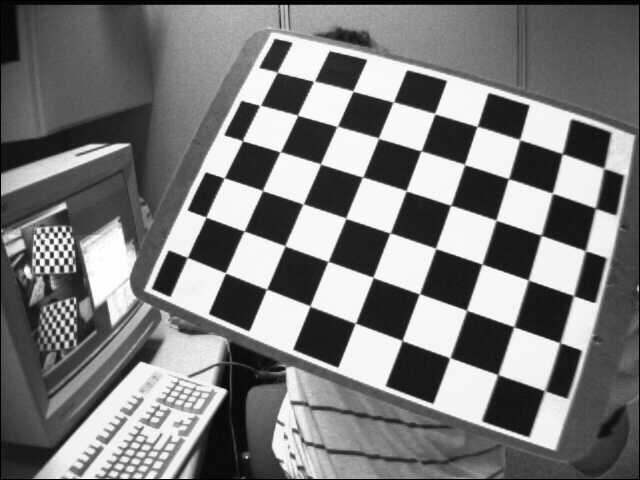

In [ ]:
ci = Intrinsics.from_test_model()
print(f'Distorted image: camera-model={ci.camera_model_name}: fx={ci.fx}, fy={ci.fy}, cx={ci.cx}, cy={ci.cy}')

root_dir = Path(os.getcwd())
if str(root_dir) not in sys.path:
    sys.path.insert(0,str(root_dir))

img_dir = root_dir / 'data' 
img_file = img_dir / 'left03.jpg'
cv_img = cv2.imread(str(img_file))

cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(cv_img)
display(pil_img)

With `alpha=1.0` all original pixels of the distorted image are kept also in the undistorted version. The drawback is that we now  many black pixels in the perimeter of the image.  

Undistrted image (alpha=1.0): camera-model=PINHOLE: fx=467.88845379768406, fy=468.28742729330503, cx=341.4258283195987, cy=236.2097112614839


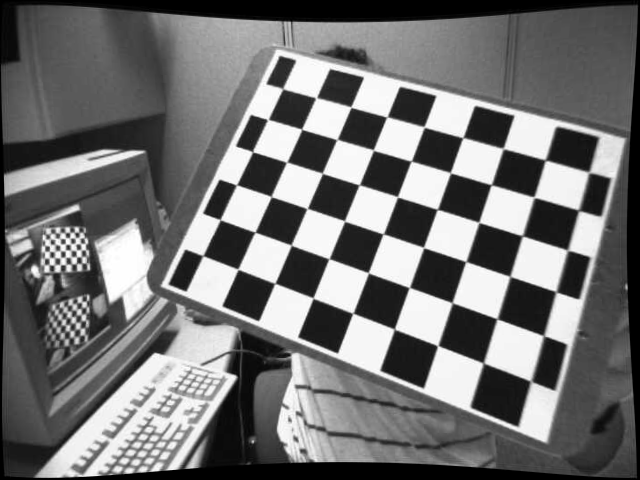

In [ ]:
alpha = 1.0
r = ci.init_undistort_rectify_map(alpha=alpha)
cp = r.pinhole_camera
print(f'Undistrted image (alpha={alpha}): camera-model={cp.camera_model_name}: fx={cp.fx}, fy={cp.fy}, cx={cp.cx}, cy={cp.cy}')

img_undistorted = Intrinsics.undistort_image(cv_img, r)
im_pil_u = Image.fromarray(img_undistorted)
display(im_pil_u)

With `alpha=0.0` value, we have no black pixels but some pixels of the original image are lost.

Undistrted image (alpha=0.0): camera-model=PINHOLE: fx=478.9090531962673, fy=502.669315116053, cx=345.568809503914, cy=235.2218688743195


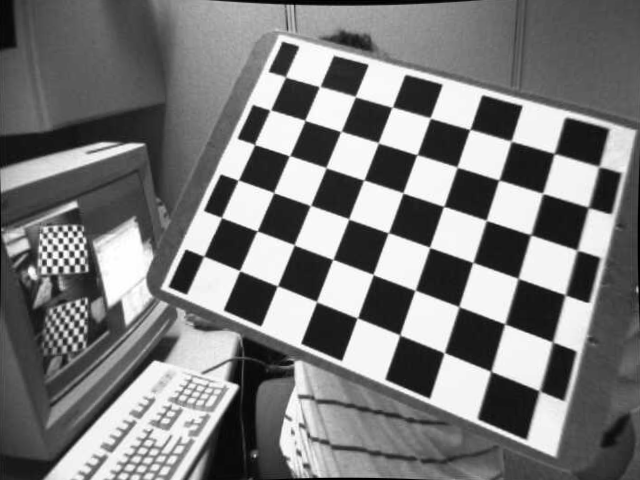

In [ ]:
alpha = 0.0
r = ci.init_undistort_rectify_map(alpha=alpha)
cp = r.pinhole_camera
print(f'Undistrted image (alpha={alpha}): camera-model={cp.camera_model_name}: fx={cp.fx}, fy={cp.fy}, cx={cp.cx}, cy={cp.cy}')

img_undistorted = Intrinsics.undistort_image(cv_img, r)
im_pil_u = Image.fromarray(img_undistorted)
display(im_pil_u)

 It is, of course,  posible to change `alpha` between 0 and 1 to control the tradeoff between number of black pixels and number of pixels in the distorted image that are lost.

Undistrted image (alpha=0.4): camera-model=PINHOLE: fx=474.50081343683405, fy=488.91655998695376, cx=343.91161703018787, cy=235.61700582918527


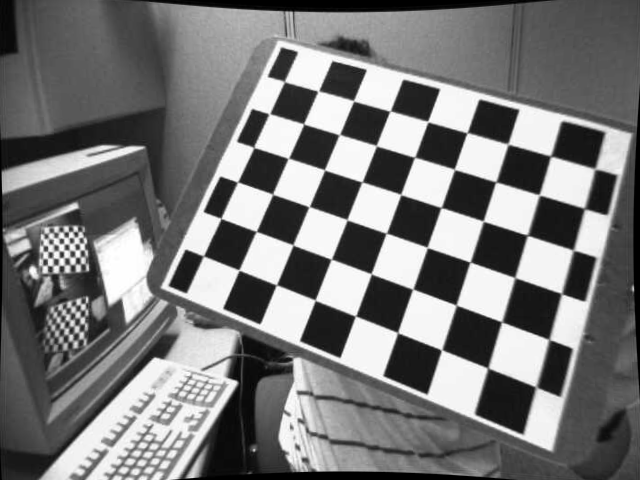

In [ ]:
alpha = 0.4
r = ci.init_undistort_rectify_map(alpha=alpha)
cp = r.pinhole_camera
print(f'Undistrted image (alpha={alpha}): camera-model={cp.camera_model_name}: fx={cp.fx}, fy={cp.fy}, cx={cp.cx}, cy={cp.cy}')

img_undistorted = Intrinsics.undistort_image(cv_img, r)
im_pil_u = Image.fromarray(img_undistorted)
display(im_pil_u)

## Project and unproject points 
Points are represented in `homogenous` coordinates or in regular Eucledian coordinates. We will denote points in hompogenous coordinates with a `tilde` so a 3D point $P$ in homogenous coordinates will be denoted by $\tilde{P}$. IN the same manner, 2D points will be written in small letters, such as $\tilde{p}$ in 2D homogenous coordinates and $p$ in 2D Eucledian space.

#### Project points

The function

In [ ]:
show_doc(Intrinsics.camera2image_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.camera2image_points

>      Intrinsics.camera2image_points (pc3d:numpy.ndarray)

Project 3D points in the camera reference coordinate system into image coordinates

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pc3d | ndarray | 3D points in camera frame system with shape (N,3) |
| **Returns** | **typing.Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]** | **A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)** |

In homegenous coordinates we have
$$
\tilde{p}_c = \begin{pmatrix} x_c \\ y_c \\ z_c \\1  \end{pmatrix}  \Rightarrow \tilde{p}_u = \begin{pmatrix} u \\ v \\ \tt{d}  \end{pmatrix}
$$
where $\tilde{p}_c$ is a 3D point in the camera coordinate system, $\tilde{p}_u$ consists of the pixel cooridates of that point, `d` is the disparity. 

The function expects regular collection of 3D points as an array of shape (N,3) and returns:

* 2D points in image plane, array of shape (N,2)
* disparitiers (inverse depth), array of shape (N,2)
* A `valid` boolean vector for indexing the valid points. 3D points for which $z$ is too close to zero are invalid


We consider two sets of 3D points in the camera coordinate system. The first set of points, `pc3d`, contains four points that can be safely projected into the image plane while the second set `pc3d_z0` contains two invalid points, with $z=0$.

In [ ]:
ci = Intrinsics.from_test_model()
pc3d =    np.array([[0.5, 0.6, 4.], [0.5, 0.6, 2.0], [0.1, 0.3, 1.5], [0.7, 0.3, 1.0]])    # 4 valid points form projection
pc3d_z0 = np.array([[0.5, 0.6, 0.], [0.5, 0.6, 2.0], [0.1, 0.3, 0,], [0.7, 0.3, 1.0]])    # 2 valid points in the set of 4 points
print(f'Using camera model: {ci.camera_model_name}, point sets with 4 3D points of shape: {pc3d.shape}')

Using camera model: OPENCV5, point sets with 4 3D points of shape: (4, 3)


In [ ]:
pi__c2i, disparity__c2i, is_valid__c2i = ci.camera2image_points(pc3d)
print(f'pc3d: {pi__c2i.shape[0]} points in image plane, disparty: {disparity__c2i.squeeze().tolist()},  is_valid: {is_valid__c2i}')

pi_z0__c2i, disparity_z0__c2i, is_valid_z0__c2i = ci.camera2image_points(pc3d_z0)
pi_z0__c2i_good = pi_z0__c2i[is_valid_z0__c2i,:]
disparity_z0__c2i_good = disparity_z0__c2i[is_valid_z0__c2i,:]

print(f'pc3d_z0: {pi_z0__c2i_good.shape[0]} good point in image plane, disparty: {disparity_z0__c2i_good.squeeze().tolist()}, is_valid: {is_valid_z0__c2i}')

pc3d: 4 points in image plane, disparty: [0.25, 0.5, 0.6666666666666666, 1.0],  is_valid: [ True  True  True  True]
pc3d_z0: 2 good point in image plane, disparty: [0.5, 1.0], is_valid: [False  True False  True]


The projection is divided into three separate operations: `project_points`, `distort_points` and `to_image_points`:

The function `project_points`

In [ ]:
show_doc(Intrinsics.project_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.project_points

>      Intrinsics.project_points (pc3d:numpy.ndarray,
>                                 projection_type:str='perspective')

Project 3D points in camera frame to 2D points in the camera plane

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| pc3d | ndarray |  | 3D points in camera frame, with shape (N,3) |
| projection_type | str | perspective | Projection type |
| **Returns** | **typing.Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]** |  | **A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)** |

Projections are covered in [Szeliski](http://szeliski.org/Book/), sec 2.1.4 in great detail. Currently we only support the perspective projection:
$$
\tilde{P}_c = \begin{pmatrix} x_c \\ y_c \\ z_c \\1  \end{pmatrix}  \Rightarrow \tilde{p}_c = \begin{pmatrix} x_c/z_c \\ y_c/z_c \\ 1  \end{pmatrix}
$$
The method `project_points` produces, in addition to the 2D points also the value of the `diaparity` (namely the inverse depth $1/z$) and the last component returned is a boolean vector `valid` for indexing the cases where the transformation was valid, in particular when $z$ was not too close to zero.

**Example**

In [ ]:
p2_undistorted, disparity, is_valid = ci.project_points(pc3d)
print(f'Points in camera plane of shape {p2_undistorted.shape}, disparty: {disparity.squeeze().tolist()}, is_valid: {is_valid}')

assert np.linalg.norm(disparity-disparity__c2i) < 1e-5, f'Assetrion failed disparity from project_points [{disparity}] not equal to disparity from camera2image_points [{disparity__c2i}]'

p2d_z0, disparity_z0, is_valid_z0 = ci.project_points(pc3d_z0)
pi_z0__good = p2d_z0[is_valid_z0,:]
disparity_z0_good = disparity_z0[is_valid_z0,:]
assert np.linalg.norm(disparity_z0__c2i_good-disparity_z0_good) < 1e-5, f'Assetrion failed: valid disparity produced by "project_points" [{disparity_z0_good}] not equal to valid disparity produced by camera2image_points [{disparity_z0__c2i_good}]'

Points in camera plane of shape (4, 2), disparty: [0.25, 0.5, 0.6666666666666666, 1.0], is_valid: [ True  True  True  True]


The `distort_points` function

In [ ]:
show_doc(Intrinsics.distort_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.distort_points

>      Intrinsics.distort_points (p_cam_undistorted:numpy.ndarray)

Distort points in the camera plane

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| p_cam_undistorted | ndarray | 2D Undistorted point in the camera plane with shape (N,2) |
| **Returns** | **ndarray** | **2D distorted point in the camera plane with shape (N,2)** |

using the distortion model as defined by the camera model: 
$$
 \tilde{p}_c = \begin{pmatrix} x_c/z_c \\ y_c/z_c \\ 1  \end{pmatrix} \Rightarrow p_d = \begin{pmatrix} x_d \\ y_d   \end{pmatrix}  = \tt{distorion\_function}(p_c)
$$
The camera models `PINHOLE` and `SIMPLE_PINHOLE` do not have distortions and then the distortion function reduces to the identity function. In all OpenCv compatible models we use the distortion function as described in [Understanding Lens Distortion](https://learnopencv.com/understanding-lens-distortion/)

**Example**

In [ ]:
p2_distorted = ci.distort_points(p2_undistorted)
print(f'Points undistorted in camera plane of shape: {p2_undistorted.shape}, first point: {p2_undistorted[0]}')
print(f'Points distorted in camera plane of shape  : {p2_distorted.shape}, first_point: {p2_distorted[0]}')

Points undistorted in camera plane of shape: (4, 2), first point: [0.125 0.15 ]
Points distorted in camera plane of shape  : (4, 2), first_point: [0.12377257 0.14860793]


It is always possible to join the `project_points` and `distort_points` into a single `project_and_distort_points` function. 

In [ ]:
show_doc(Intrinsics.project_and_distort_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.project_and_distort_points

>      Intrinsics.project_and_distort_points (pc3d:numpy.ndarray)

Project 3D points in the camera reference coordinate system into 2D distorted points in the camera frame

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pc3d | ndarray | 3D points in camera frame system with shape (N,3) |
| **Returns** | **typing.Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]** | **A 2D point in the camera plane with shape (N,2), disparities with shape (N,1) and boolean valid mask with shape (N,)** |

For OpenCv camera model, exceept `OPENCV5`, that use the either the function [projectPoints](https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c) or the function [fisheye.projectPoints](https://docs.opencv.org/4.5.4/db/d58/group__calib3d__fisheye.html#gab1ad1dc30c42ee1a50ce570019baf2c4) there is no way of calling to `project_points` and `distort_points` separatly so the only option is calling to `project_and_distort_points`

In [ ]:
ci_cv = Intrinsics.from_test_model(as_full_opencv=True)   # construct full OpenCv caera model
print(f'camera model: {ci.camera_model_name}')
p2_distorted_cv, disparity_cv, is_valid_cv = ci_cv.project_and_distort_points(pc3d)
print(f'Points in camera plane (project_and_distort_points): {p2_distorted_cv.shape}, disparty: {disparity_cv.squeeze().tolist()}, is_valid: {is_valid_cv}')

p2d_z0_cv, disparity_z0_cv, is_valid_z0_cv = ci_cv.project_and_distort_points(pc3d_z0)
print(f'Good points in camera plane (project_and_distort_points): {p2d_z0_cv[is_valid_z0_cv].shape}, disparty: {disparity_z0_cv[is_valid_z0_cv].squeeze().tolist()}, is_valid: {is_valid_z0_cv}')

camera model: OPENCV5
Points in camera plane (project_and_distort_points): (4, 2), disparty: [0.25, 0.5, 0.6666666666666666, 1.0], is_valid: [ True  True  True  True]
Good points in camera plane (project_and_distort_points): (2, 2), disparty: [0.5, 1.0], is_valid: [False  True False  True]


For non OpenCv camera models the result of calling to `project_and_distort_points` to first calling to `project_points` and then calling to `distort_points`: 

In [ ]:
p2_distorted_1, disparity_1, valid_1 = ci.project_and_distort_points(pc3d)

err_p2u_project_and_distort_points = np.linalg.norm(p2_distorted-p2_distorted_1)
assert  err_p2u_project_and_distort_points < 1e-5, f'Assertion error. Error in results of "project_and_distort_points" vs  "project_points" and "distort_points" is too large: {err_p2u_project_and_distort_points}'

The function `to_image_points`

In [ ]:
show_doc(Intrinsics.to_image_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.to_image_points

>      Intrinsics.to_image_points (pc_distorted:numpy.ndarray)

Transform points from the camera plane to the image plane, using the camera matrix K

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pc_distorted | ndarray | 2D points in the camera plane with shape (N,2) |
| **Returns** | **ndarray** | **2D points in the image plane with shape (N,2)** |

In homogous coordinates the transformation is:
$$
 \begin{pmatrix} u \\ v  \\ 1 \end{pmatrix} = \begin{pmatrix} f_x & 0 & c_x   \\  0 & f_y & c_y  \\ 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} x_d \\ y_d  \\ 1 \end{pmatrix} = K \begin{pmatrix} x_d \\ y_d  \\ 1 \end{pmatrix} 
$$

In [ ]:
p_image = ci.to_image_points(p2_distorted)
print(f'Shape of pixels points: {p_image.shape}, first point: {p_image[0]}')

Shape of pixels points: (4, 2), first point: [408.61482149 315.21215808]


#### Unproject  points

The unprojection functions is about transforming back pixels into 3D points which is in general impossible, unless we know the `disparity`

First we transform image pixels into tha camera plane:

In [ ]:
show_doc(Intrinsics.to_camera_points)

---

[source](https://github.com/srippa/mvgutils//blob/main/mvgutils/intrinsics.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Intrinsics.to_camera_points

>      Intrinsics.to_camera_points (pu:numpy.ndarray)

Transform pixel image coordinates into the distorted camera plane

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pu | ndarray | points in the image plane, shape is (N,2) |
| **Returns** | **ndarray** | **points in distorted camera plane, shape (N,2)** |

Namely 
$$
 \begin{pmatrix} x_d \\ y_d  \\ 1 \end{pmatrix}  = k^{-1} \begin{pmatrix} u \\ v  \\ 1 \end{pmatrix} 
$$
where 
$$
k^{-1} =  \begin{pmatrix} 1/f_x & 0 & -c_x/f_x   \\  0 & 1/f_y & -c_y/f_y  \\ 0 & 0 & 1 \end{pmatrix}
$$

In [ ]:
p2_distorted_back_projected = ci.to_camera_points(p_image)   # transform form image plane to distorted camera plane

err_distortion_backprojection_1 = np.linalg.norm(p2_distorted_back_projected-p2_distorted)
assert err_distortion_backprojection_1 < 1e-5, f'Assertion failed error of unptojection to camera plane [{err_distortion_backprojection_1}] is too large'

The next step is to undistort the points in the image plane. 

In [ ]:
show_doc(Intrinsics.undistort_points)

AttributeError: type object 'Intrinsics' has no attribute 'undistort'

I most cases, this procedure involves solving a polynomial equation by Newton iterations. The procedure converges very fast, and we use the OpenCv conventions and restrict the number of iterations to 17.

In [ ]:
p2_undistorted_back_projected = ci.undistort_points(p2_distorted_back_projected)

err_undistortion_backprojection_1 = np.linalg.norm(p2_undistorted_back_projected-p2_undistorted)
assert err_undistortion_backprojection_1 < 1e-5, f'Assertion failed error of unptojection to camera plane [{err_undistortion_backprojection_1}] is too large'

Finally we convert from the undistorted camera plane to the 3D camera coordinate system

#### Tests

In [ ]:
import os
import sys
from pathlib import Path
import cv2

ci = Intrinsics.from_test_model()                         # OPENCV5
ci_cv = Intrinsics.from_test_model(as_full_opencv=True)   # same model as ci but defined as OPENCV modxel with last 3 distortion coeffs = 0
print(f'full cv camera model: {ci_cv.camera_model_name}')

print(f'Test camera of type  {ci.camera_model_name}')

# twopoints
points_camera = np.array(
    [
        [0.5, 0.5,1.],
        [0.5,0.5,2.],
        [0.5,0.5,1.4]
    ]
)



p2d_cv, d_cv, is_valid_cv = ci_cv.project_and_distort_points(points_camera)  # OPENCV5 model  not handled by OpenCv functions
p2d, d, is_valid = ci.project_and_distort_points(points_camera)              # FULL_OPENCV model handled by OpenCv functions, same as OPENCV5 since last 3 distortion params are zero
err_pts = np.linalg.norm(p2d_cv-p2d)
err_d = np.linalg.norm(d_cv-d)
assert err_pts < 1e-5, f'assersion failed comparing project_and_distort_points points to OpenCv [{err_pts}]'
assert err_d < 1e-5, f'assersion failed comparing project_and_distort_points disparities to OpenCv [{err_d}]'

# Test 1 : camera2image_points model to OpenCv computation
pimage, disparity, valid = ci.camera2image_points(points_camera)

no_rot = np.array([[0.0], [0.0], [0.0]])
no_trans = np.array([[0.0], [0.0], [0.0]])
pimage_cv, _ =  cv2.projectPoints(points_camera,                              # project to image
                           no_rot,
                           no_trans,
                           ci.K_3,
                           ci.distortions)
pimage_cv = pimage_cv.squeeze(1)

# compare mvgutils to output of OpenCv
err_test_1 = np.linalg.norm(pimage_cv-pimage)
assert err_test_1 < 1e-5,  f'assersion failed distance between and OpenCV is too large [{err_test_1}]'


# Test 2 : transform from camera pixels to distgorted camera plane and then undistort
pd = ci.to_camera_points(pimage)
pu = ci.undistort_points(pd)

ppp = np.expand_dims(pimage,1)
cv_undistorted =  cv2.undistortPoints(ppp, ci.K_3, ci.distortions).squeeze()

err_test_2 = np.linalg.norm(pu-cv_undistorted)
assert err_test_2 < 1e-5, f'assersion failed distance between and OpenCV is too large [{err_test_2}]'


full cv camera model: FULL_OPENCV
Test camera of type  OPENCV5


In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()